<a href="https://colab.research.google.com/github/68291410/Project-Kelompok/blob/main/CUSTOMER_SEGMENTATION_PT_XYZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CUSTOMER SEGMENTATION - PT XYZ

#### PROBLEM STATEMENT & STUDY CASE

PT XYZ adalah perusahaan teknologi yang bergerak di bidang retail
makanan. Produk utama dari perusahaan ini adalah aplikasi pemesanan
makanan. Di aplikasi ini customer dapat memesan makanan berlebih dari
toko makanan, yang berpotensi tersia-siakan apabila tidak habis terjual
sebelum waktu tertentu (flash food sale) atau di penghujung hari (closing
hour discount/clearance sale). Aplikasi ini berperan sebagai perantara
antara Rekan mitra dan customer individual.
<br><br>
Data yang digunakan adalah data transaksi dan item pembelian user dari
aplikasi dengan range waktu 1 tahun, yakni dari periode April 2021 hingga
Mei 2022. Anda diminta untuk menganalisa:
User yang dikelompokkan menggunakan metode clustering sehingga
didapatkan analisis buying behavior yang dapat menjelaskan bagaimana
karakteristik dari repeat customer dan faktor lain seperti lokasi user, lokasi
merchant, item yang dibeli, dan lain-lain.
<br><br>
Tujuan dari analisis ini:
1.   Dapat menghasilkan segmentasi-segmentasi pelanggan dari data yang diberikan.
2.   Dapat memberikan rekomendasi yang actionable untuk
setiap segmentasi yang ditemukan.

Deskripsi Data yang dimiliki adalah sebagai berikut:
<br>


*   Data Merchant


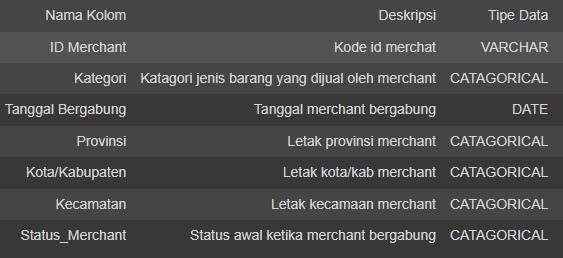
<br><br>

*  Data Transaksi


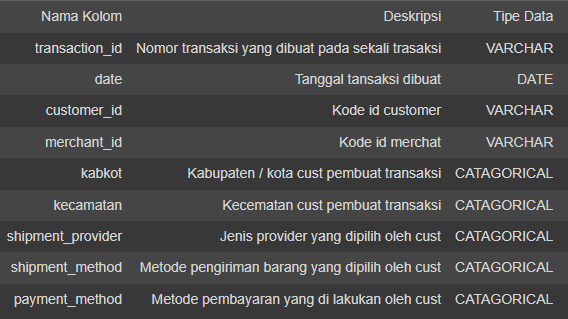

#### IMPORT PACKAGES

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

#------------------------------------------------#
#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#------------------------------------------------#
#Modelling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn .preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

#### READ DATASET

In [4]:
# connect colab ke g drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path = '/content/gdrive/MyDrive/Dataset'
# Cek directory
os.listdir(path)

['Data_Merchant_PT_XYZ.csv',
 'Metadata Data Transaksi.csv',
 'Metadata Data Merchant.csv',
 'Data_Transaction_PT_XYZ.csv']

In [ ]:
# Load Data Merchant
df1 = pd.read_csv(os.path.join(path, "Data_Merchant_PT_XYZ.csv"))
df1.head()

,ID Merchant,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant
0,7890,Supermarket,2020-03-10 4:57:09,NaN,NaN,NaN,Platinum
1,2033,Supermarket,2020-03-26 13:12:10,JAWA BARAT,KOTA BANDUNG,ANTAPANI,Platinum
2,2390,Supermarket,2020-05-10 6:30:18,NaN,NaN,NaN,Platinum
3,9916,Supermarket,2020-06-05 10:28:19,NaN,NaN,NaN,Gold
4,5969,Supermarket,2020-06-19 7:17:39,DKI JAKARTA,KOTA JAKARTA BARAT,PALMERAH,Gold


In [ ]:
# Load Data Transaksi
df2 = pd.read_csv(os.path.join(path, "Data_Transaction_PT_XYZ.csv"))
df2.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana
2,486273,2021-04-02 22:01:00,4054,8906,KOTA BOGOR,BOGOR BARAT,GOSEND,Instant,Dana
3,694230,2021-04-04 14:20:00,4005,5738,KOTA BANDUNG,LENGKONG,SELF PICKUP,-,Dana
4,762056,2021-04-04 21:39:00,4110,7890,NaN,NaN,GOSEND,Instant,ShopeePay


#### DATA PREPARATION

Cek Missing Value

In [ ]:
# Memunculkan informasi jumlah data dan tipe data tiap kolom dataset Merchant.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID Merchant        550 non-null    int64 
 1   Kategori           550 non-null    object
 2   Tanggal Bergabung  550 non-null    object
 3   Provinsi           339 non-null    object
 4   Kota/Kabupaten     339 non-null    object
 5   Kecamatan          339 non-null    object
 6   Status_Merchant    550 non-null    object
dtypes: int64(1), object(6)
memory usage: 30.2+ KB


In [ ]:
# Mengecek berapa jumlah null value pada masing masing kolom.
jumlah_missing1 = pd.isnull(df1).sum()
jumlah_missing1

ID Merchant            0
Kategori               0
Tanggal Bergabung      0
Provinsi             211
Kota/Kabupaten       211
Kecamatan            211
Status_Merchant        0
dtype: int64

In [ ]:
# menghitung ratio missing value 1
rasio1 = jumlah_missing1.div(len(df1))
rasio1

ID Merchant          0.000000
Kategori             0.000000
Tanggal Bergabung    0.000000
Provinsi             0.383636
Kota/Kabupaten       0.383636
Kecamatan            0.383636
Status_Merchant      0.000000
dtype: float64

missing value pada data 1 sebesar 38% pada kolom lokasi (Provinsi, Kota/Kabupaten, Kecamatan) yang bertype object. Untuk mengatasi missing value menggunakan drop baris, karena jika mengatasi missing value menggunakan inputing modus pada kolom lokasi takut tidak make sense.

In [ ]:
#menghapus baris yang terdapat missing
df1 = df1.dropna(axis = 0, how = 'any')

In [ ]:
# Mengecek kembali jumlah null value pada masing masing kolom.
jumlah_missing = pd.isnull(df1).sum()
jumlah_missing

ID Merchant          0
Kategori             0
Tanggal Bergabung    0
Provinsi             0
Kota/Kabupaten       0
Kecamatan            0
Status_Merchant      0
dtype: int64

In [ ]:
# Memunculkan informasi jumlah data dan tipe data tiap kolom dataset sales.
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3341 entries, 0 to 3340
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   transaction_id     3341 non-null   int64 
 1   date               3341 non-null   object
 2   customer_id        3341 non-null   int64 
 3   merchant_id        3341 non-null   int64 
 4   kabkot             3179 non-null   object
 5   kecamatan          3179 non-null   object
 6   shipment_provider  3341 non-null   object
 7   shipment_method    3341 non-null   object
 8   payment_method     3341 non-null   object
dtypes: int64(3), object(6)
memory usage: 235.0+ KB


In [ ]:
# Mengecek berapa jumlah null value pada masing masing kolom.
jumlah_missing2 = pd.isnull(df2).sum()
jumlah_missing2

transaction_id         0
date                   0
customer_id            0
merchant_id            0
kabkot               162
kecamatan            162
shipment_provider      0
shipment_method        0
payment_method         0
dtype: int64

In [ ]:
# menghitung ratio missing value 2
rasio2 = jumlah_missing2.div(len(df2))
rasio2

transaction_id       0.000000
date                 0.000000
customer_id          0.000000
merchant_id          0.000000
kabkot               0.048488
kecamatan            0.048488
shipment_provider    0.000000
shipment_method      0.000000
payment_method       0.000000
dtype: float64

missing value pada data 2 sekitar 0,04% pada kolom lokasi (Provinsi, Kota/Kabupaten, Kecamatan) yang bertype object. Untuk mengatasi missing value menggunakan drop baris, karena jika mengatasi missing value menggunakan inputing modus pada kolom lokasi takut tidak make sense.

In [ ]:
#menghapus baris yang terdapat missing
df2 = df2.dropna(axis = 0, how = 'any')

In [ ]:
# Mengecek kembali jumlah null value pada masing masing kolom.
jumlah_missing = pd.isnull(df2).sum()
jumlah_missing

transaction_id       0
date                 0
customer_id          0
merchant_id          0
kabkot               0
kecamatan            0
shipment_provider    0
shipment_method      0
payment_method       0
dtype: int64

Duplicate Data

In [ ]:
#cek duplicate
duplicate = df1[df1.duplicated()]
duplicate

,ID Merchant,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant


In [ ]:
#cek duplicate
duplicate = df2[df2.duplicated()]
duplicate

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method


tidak ada duplicate pada data 1 dan 2

JOIN DATA MERCHANT DAN DATA TRANSAKSI

In [ ]:
df1 = df1.rename(columns={"ID Merchant" : "merchant_id"})
df1.head()

,merchant_id,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant
1,2033,Supermarket,2020-03-26 13:12:10,JAWA BARAT,KOTA BANDUNG,ANTAPANI,Platinum
4,5969,Supermarket,2020-06-19 7:17:39,DKI JAKARTA,KOTA JAKARTA BARAT,PALMERAH,Gold
7,5376,Bakery,2020-08-13 12:15:23,BANTEN,KOTA TANGERANG,CIPONDOH,Gold
10,5407,Coffe Shop,2020-08-27 4:50:47,DKI JAKARTA,KOTA JAKARTA TIMUR,KRAMAT JATI,Silver
11,8629,Traditional Restaurant,2020-08-28 5:30:32,JAWA BARAT,KABUPATEN BOGOR,SUKARAJA,Bronze


In [ ]:
df = df2.merge(df1,left_on='merchant_id',right_on='merchant_id')
df.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver


#### FEATURE ENGINEERING

MENAMBAHKAN KOLOM BARU YAITU "JAM", "HARI", "BULAN", DAN "WEEKDAY"

In [ ]:
# Menambahkan kolom 'hari', 'bulan', dan 'weekday' saat transaksi
df['date'] = pd.to_datetime(df['date'])
df['Jam'] = df['date'].dt.hour
df['Hari'] = df['date'].dt.day_name()
df['Bulan'] = df['date'].dt.month_name()
df['Year'] = df['date'].dt.year
df['Weekday'] = df['date'].dt.dayofweek // 5 == 0
df.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant,Jam,Hari,Bulan,Year,Weekday
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,21,Monday,April,2021,True
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,22,Saturday,April,2021,False
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,14,Saturday,April,2021,False
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,13,Tuesday,April,2021,True
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,17,Tuesday,April,2021,True


In [ ]:
df['Week'] = df['Weekday'].apply(lambda x: 'Weekday' if x else 'Weekend')
df.drop('Weekday', axis=1, inplace=True)
df.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant,Jam,Hari,Bulan,Year,Week
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,21,Monday,April,2021,Weekday
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,22,Saturday,April,2021,Weekend
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,14,Saturday,April,2021,Weekend
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,13,Tuesday,April,2021,Weekday
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,17,Tuesday,April,2021,Weekday


#### EXPLORATOTY DATA ANALYSIS

EDA adalah pendekatan untuk menganalisis kumpulan data untuk merangkum karakteristik utamanya, seringkali dengan metode visual, yang mana pada data frame ini akan menganalisis kumpulan data yang dibutuhkan oleh PT XYZ untuk memberikan rekomendasi yang actionable untuk setiap segmentasi yang ditemukan.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3179 entries, 0 to 3178
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_id     3179 non-null   int64         
 1   date               3179 non-null   datetime64[ns]
 2   customer_id        3179 non-null   int64         
 3   merchant_id        3179 non-null   int64         
 4   kabkot             3179 non-null   object        
 5   kecamatan          3179 non-null   object        
 6   shipment_provider  3179 non-null   object        
 7   shipment_method    3179 non-null   object        
 8   payment_method     3179 non-null   object        
 9   Kategori           3179 non-null   object        
 10  Tanggal Bergabung  3179 non-null   object        
 11  Provinsi           3179 non-null   object        
 12  Kota/Kabupaten     3179 non-null   object        
 13  Kecamatan          3179 non-null   object        
 14  Status_M

In [ ]:
# mengetahui ukuran data baris dan kolom
print("ukuran data :", df.shape)

ukuran data : (3179, 20)


untuk ukuran data merchant adalah dengan 3179 baris dan 20 kolom, yang terdiri dari transaction_id, date, customer_id, merchant_id, kabkot, kecamatan, shipment_provider, shipment_method, payment_method, Kategori, Tanggal Bergabung, Provinsi, Kota/Kabupaten, Kecamatan, Status_Merchant, Jam, Hari, Bulan, Year dan Weekday.

In [ ]:
df.nunique()

transaction_id       3179
date                 3142
customer_id          1509
merchant_id           144
kabkot                 21
kecamatan              82
shipment_provider       3
shipment_method         3
payment_method          5
Kategori                9
Tanggal Bergabung     144
Provinsi                6
Kota/Kabupaten         21
Kecamatan              82
Status_Merchant         4
Jam                    23
Hari                    7
Bulan                  12
Year                    2
Week                    2
dtype: int64

Dari data frame terdapat kode transaction yang uniq yaitu  3179 transaction_id, terdapat customer 1509 yang membeli 144 merchant yang terbagi menjadi 9 kategori. Merchent tersebut menempati 6 provinsi khususnya di 82 kacamatan yang berada di 21 kota/kabupaten dari provinsi tersebut. 144 merchant tersebut memiliki status masing-masing, dimana status merchant terdapat 4 macam. Customer tersebut melakukan transaksi menggunakan 3 metode pengiriman dan 5 metode pembayaran.

1. Melihat Item yang dijual oleh setiap merchant

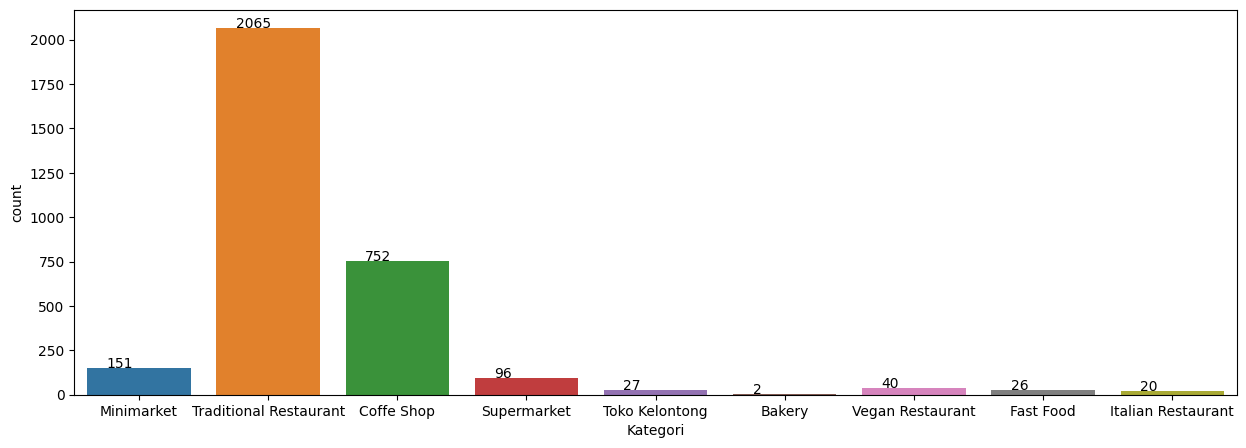

In [ ]:
#1. analisis Merchant/item yang dijual
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='Kategori', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

Visualisasi diatas terdapat 144 merchant yang terbagi menjadi 9 kategori yaitu 151 minimarket, 2065 traditional restaurant, 752 coffe shop, 96 supermarket, 27 toko kelontong, 2 bakery, 40 vegan restaurant, 26 fast food, dan 20 italia restaurant. Merchant yang paling banyak adalah traditional restaurant.
Dapat disimpulkan bahwa customer lebih sering membeli atau memesan makanan berlebih dari traditional restaurant.


2. Analisis Lokasi Merchant

In [ ]:
# a) Analisis Lokasi Merchant Berdasarkan Kecamatan
merchant_customer = df['Kecamatan'].value_counts().iloc[:10].reset_index()
merchant_customer.columns = ['Kecamatan', 'Jumlah Kecamatan']
merchant_customer

,Kecamatan,Jumlah Kecamatan
0,SUMUR BANDUNG,405
1,MERGANGSAN,300
2,DEPOK,271
3,KEBAYORAN BARU,233
4,BATUNUNGGAL,220
5,GROGOL PETAMBURAN,198
6,BANDUNG WETAN,131
7,ANTAPANI,128
8,MATRAMAN,127
9,SUKASARI,124


<ipython-input-27-bed0c4e71299>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='right',fontsize=8);


Text(0.5, 1.0, 'Top 10 Kecamatan')

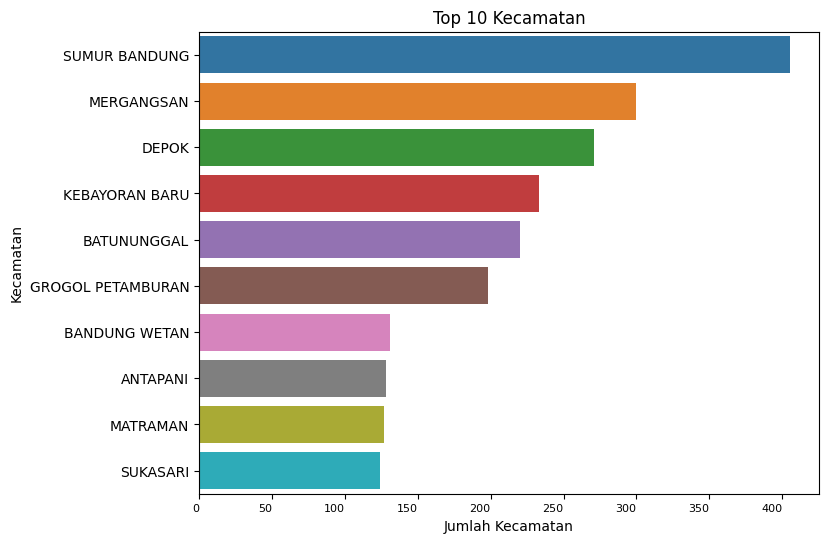

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x='Jumlah Kecamatan', y='Kecamatan', data=merchant_customer);
ax.set_xticklabels(ax.get_xticklabels(), ha='right',fontsize=8);
plt.title("Top 10 Kecamatan")

Visualisasi diatas menggambarkan 10 top kecamatan yang ditempati 9 merchant yaitu Kecamatan Sumur Bandung, Mergangsang, Depok, Kabayoran Baru, Batununggal, Grogol Petamburan, Bandung Wetan, Antapani, Mataraman, dan Sukasari. Dimana Sumur Bandung yang mendominasi diantara 10 top Kecamatan tersebut.

In [ ]:
# b)  Analisis Lokasi Merchant Berdasarkan Berdasarkan Kabupaten/Kota
merchant_customer = df['Kota/Kabupaten'].value_counts().iloc[:10].reset_index()
merchant_customer.columns = ['Kota/Kabupaten', 'Jumlah Kota/Kabupaten']
merchant_customer

,Kota/Kabupaten,Jumlah Kota/Kabupaten
0,KOTA BANDUNG,1241
1,KOTA JAKARTA SELATAN,434
2,KOTA YOGYAKARTA,391
3,KABUPATEN SLEMAN,299
4,KOTA JAKARTA TIMUR,254
5,KOTA JAKARTA BARAT,225
6,KOTA JAKARTA PUSAT,82
7,KOTA DEPOK,57
8,KOTA MALANG,33
9,KOTA DENPASAR,28


<ipython-input-29-d6864f0d924a>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='right',fontsize=8);


Text(0.5, 1.0, 'Top 10 Kota/Kabupaten')

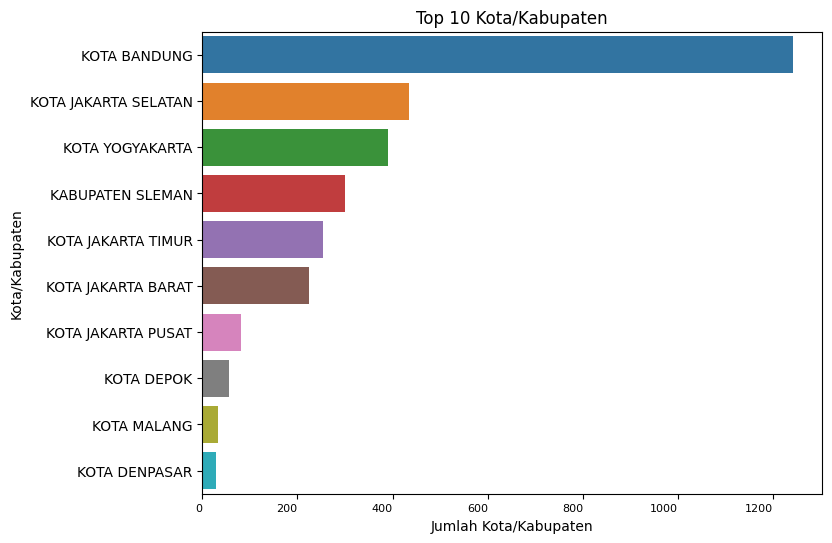

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x='Jumlah Kota/Kabupaten', y='Kota/Kabupaten', data=merchant_customer);
ax.set_xticklabels(ax.get_xticklabels(), ha='right',fontsize=8);
plt.title("Top 10 Kota/Kabupaten")

Visualisasi diatas menggambarkan 10 top Kota/Kabupaten yang ditempati 9 merchant yaitu Kota Bandung, Jakarta Selatan, Yogyakarta, Kabupaten Sleman, Jakarta Timur, Jakarta Barat, Jakarta Pusat, Depok, Malang, dan Denpasar. Dimana Kota Bandung yang mendominasi diantara 10 top Kota/Kabupaten tersebut. Sehinngga top 1 kecamatan yang ditempati merchant belum tentu berada di top 1 Kota/Kabupaten yang ditempati merchant.

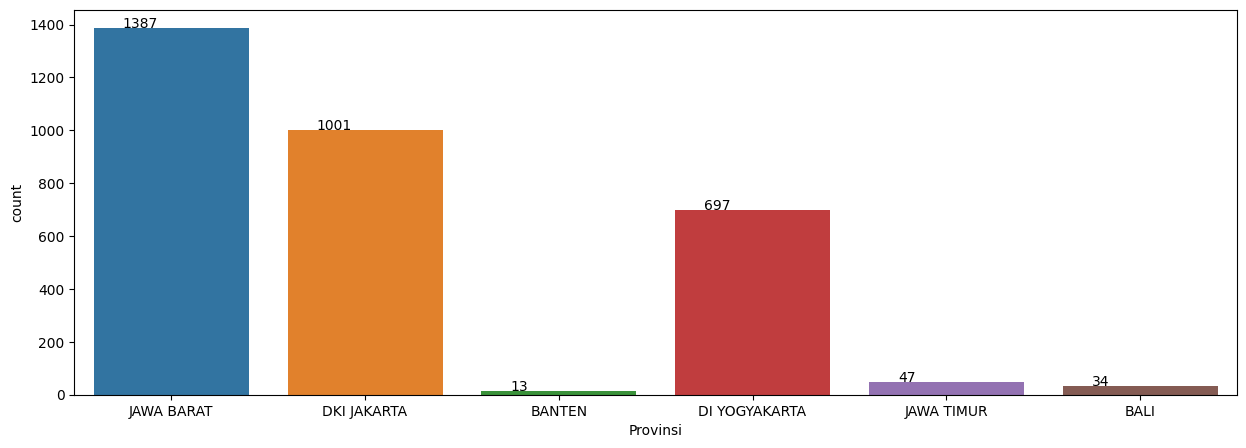

In [ ]:
# c) analisis lokasi merchant berdasarkan Provinsi
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='Provinsi', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

Visualisasi diatas terdapat 8 Provinsi yang diempati oleh 9 merchant. Dimana posisi pertama ada Jawa Barat merupakan provinsi yang paling banyak ditempati merchant, kedua DKI Jakarta merupakan provinsi yang paling banyak kedua ditempati merchant, ketiga DI Yogyakarta merupakan provinsi yang paling banyak ketiga ditempati merchant sehingga top 1 Kecamatan dan Kota/Ibukota belum tentu berada di provinsi yang paling banyak ditempati merchant.


3. Analisis status Merchant

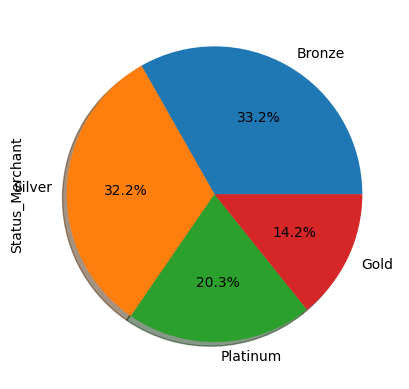

In [ ]:
df['Status_Merchant'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)
plt.show()

Visualisasi diatas, terlihat bahwa terdapat 4 status merchant, yang mana Bronze yang paling mendominasi, lalu disusul dengan platinum, gold, dan silver, dengan masing-masing nilai presentase 33.2%, 32.2%, 20.3%, dan 14.2%.

4. Analisis Pengiriman

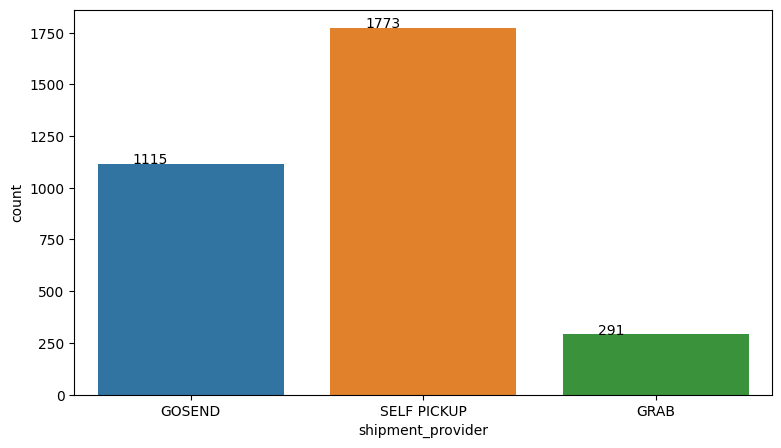

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='shipment_provider', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

Visualisasi diatas terlihat bahwa Customer/User melakukan pengambilan item menggunakan SELF PICKUP sebanyak 1773, GOSEND sebanyak 1115, dan GRAB sebanyak 291. Sehingga dapat dikatakan bahwa Customer/User lebih suka melakukan pengambilan item menggunakan SELF PICKUP dibandingkan dengan GOSEND dan GRAB.

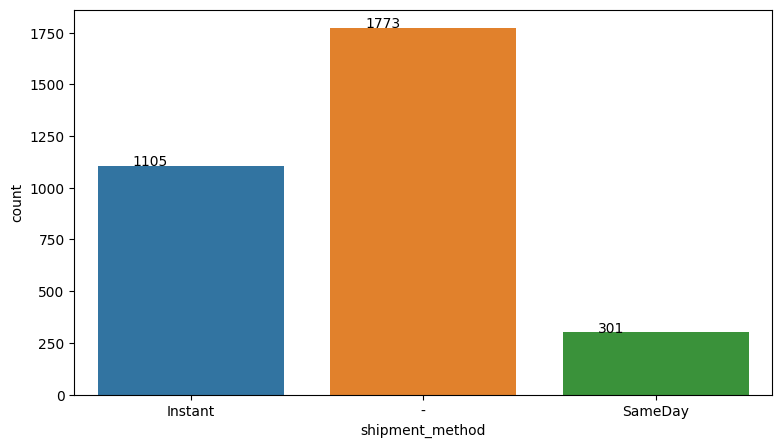

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='shipment_method', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

Pada pengiriman yang dipilih oleh customer terdapat 3 metode pengiriman yaitu Secara Langsung, Instant, dan Same Day. 1773 Customer lebih banyak melakukan transaksi secara langsung ke lokasi merchant itu dijual, yang menggunakan pengiriman instant atau pengiriman cepat dengan estimasi pengiriman lebih cepat dibandingkan dengan pengiriman sameday yaitu 1105 customer menggunakan pemgiriman ini, sedangkan yang menggunakan sameday hanya 301 customer.

5. Analisis Metode Pembayaran

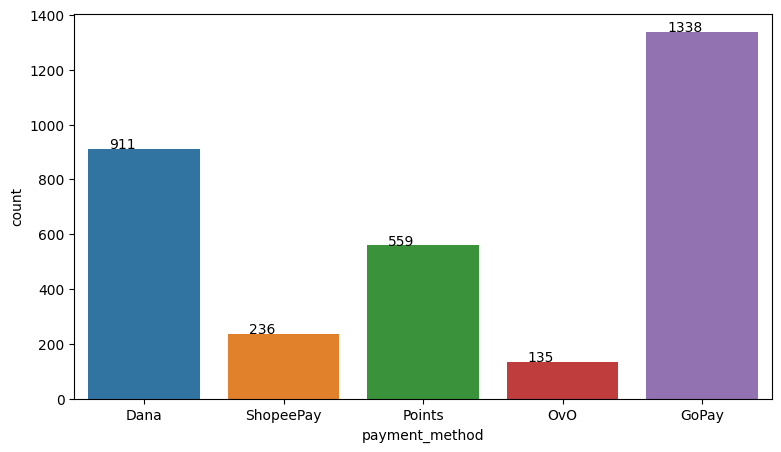

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='payment_method', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

Visualisasi diatas terdapat 5 metode pembayaran yang digunakan oleh Customer/User yaitu Dana, ShopeePay, Points,  OvO, dan GoPay. Dimana terdapat 911 Customer/User melakukan pembayaran dengan Dana,  236 Customer/User melakukan pembayaran dengan ShopeePay,  559 Customer/User melakukan pembayaran dengan Point, 135 Customer/User melakukan pembayaran dengan Ovo, dan 1338 Customer/User melakukan pembayaran dengan GoPay. Sehingga dapat dikatakan bahwa Customer/User lebih suka melakukan pembayaran menggunakan GoPay.

6. Melihat jumlah transaksi, dan pelanggan

In [ ]:
cust_x_prod = pd.DataFrame([{'transactions':len(df['transaction_id'].value_counts()),
'customers': len(df['customer_id'].value_counts()),}],
columns = ['transactions','customers'], index = ['quantity'])
print(cust_x_prod)

          transactions  customers
quantity          3179       1509


Output diatas terdapat 1509 customer dan 3179  transactions. Sehingga dapat dikatakan bahwa terdapat customer yang melakukan transaksi lebih dari 1 kali transaksi.

7. Melihat jumlah transaksi pertahun

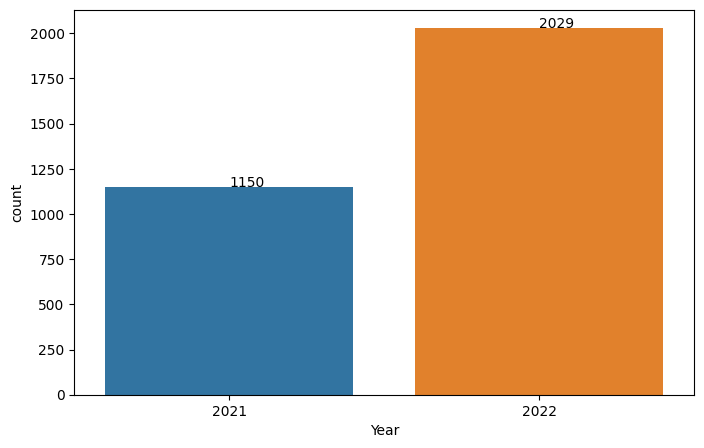

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='Year', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.40, s.get_height()+1))

Jumlah transaksi paling banyak terjadi pada tahun 2022 dengan total 2029 transaksi, sedangkan tahun 2021 dengan total 1150 transaksi.

8. Melihat jumlah transaki bulanan

Transaksi Tahun 2021

In [ ]:
tahun21 = df[df['Year'] == 2021]

In [ ]:
bulan21 = tahun21['Bulan'].value_counts().reset_index()
bulan21.columns = ['Bulan', 'Jumlah Bulan']
bulan21

,Bulan,Jumlah Bulan
0,December,238
1,September,237
2,November,157
3,August,148
4,October,140
5,July,104
6,June,59
7,April,35
8,May,32


In [ ]:
!pip install sort-dataframeby-monthorweek

!pip install sorted-months-weekdays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sort-dataframeby-monthorweek: filename=sort_dataframeby_monthorweek-0.4-py3-none-any.whl size=3420 sha256=6240c94ac2a89065735e4eea5181996e424259b018ee859b9120a30fc6b37857
  Stored in directory: /root/.cache/pip/wheels/6b/fd/39/06eaac8d65d641f9f50856a48b57a5ec8351be2874beff01ec
Successfully built sort-dataframeby-monthorweek
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sorted-months-weekdays: filename=sorted_months_weekdays-0.2-py3-none-any.whl size=3223 sha256=9170e21d48fb273364fd4efed32a6372dc139e548b20059e8f26b405ac6713f3
  Stored in directory: /root/.cache/pip/wheels/bd/b4/f6/2c29a96668a9a13a568134857fd7b7a5186261f00f1d35661c
Successfully built sorted-months-weekdays


In [ ]:
import sort_dataframeby_monthorweek as sd
def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)

In [ ]:
bulan21 = sort_month(bulan21, 'Bulan')
bulan21

,Bulan,Jumlah Bulan
0,April,35
1,May,32
2,June,59
3,July,104
4,August,148
5,September,237
6,October,140
7,November,157
8,December,238


In [ ]:
plt.figure(figsize = (8, 8))
px.line(bulan21, x="Bulan", y=["Jumlah Bulan"])

<Figure size 800x800 with 0 Axes>

Transaksi pertahun 2021 mengalami kenaikan yang cukup signifikan dari bulan agustus hingga september, dan mengalami penurunan pada bulan Oktober, Namun mengalami kenaikan kembali pada bulan November hingga Desember.

Tahun 2022

In [ ]:
tahun22 = df[df['Year'] == 2022]
bulan22 = tahun22['Bulan'].value_counts().reset_index()
bulan22.columns = ['Bulan', 'Jumlah Bulan']
bulan22

,Bulan,Jumlah Bulan
0,April,612
1,March,482
2,May,396
3,February,288
4,January,206
5,June,45


In [ ]:
bulan22 = sort_month(bulan22, 'Bulan')
bulan22

,Bulan,Jumlah Bulan
0,January,206
1,February,288
2,March,482
3,April,612
4,May,396
5,June,45


In [ ]:
plt.figure(figsize = (24, 12))
px.line(bulan22, x="Bulan", y=["Jumlah Bulan"])

<Figure size 2400x1200 with 0 Axes>

Transaksi pertahun 2022 mengalami kenaikan yang cukup stabil dari bulan Januari sampai bulan April, namun mengalami penurunan yang sangat signifikan dari mulai bulan mei hingga juni.

8. Melihat jumlah transaksi setiap harinya

In [ ]:
hari = df['Hari'].value_counts().reset_index()
hari.columns = ['Hari', 'Jumlah Hari']
hari

,Hari,Jumlah Hari
0,Saturday,531
1,Friday,490
2,Thursday,442
3,Monday,440
4,Sunday,434
5,Wednesday,431
6,Tuesday,411


In [ ]:
import plotly.express as px

# Sort the days in chronological order
hari['Hari'] = pd.Categorical(hari['Hari'], categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ordered=True)
hari.sort_values('Hari', inplace=True)

# Create the line plot
plt.figure(figsize=(24, 12))
line_plot = px.line(hari, x="Hari", y="Jumlah Hari")

# Show the line plot
line_plot.show()


<Figure size 2400x1200 with 0 Axes>

Pembelian customer lebih bnayak dilakukan pada hari sabtu dengan customer 531 dibandingkan hari lainnya, tapi pada hari weekday pembelian customer stabil dan tidak terlalu banyak jumlah penurunnya.

9. Melihat jumlah transaksi setiap mingguannya

In [ ]:
weekday_hari = df[df['Week'] == 'Weekday']['Hari'].unique()
weekend_hari = df[df['Week'] == 'Weekend']['Hari'].unique()

print("Hari-hari pada Weekday:", weekday_hari)
print("Hari-hari pada Weekend:", weekend_hari)

Hari-hari pada Weekday: ['Monday' 'Tuesday' 'Thursday' 'Friday' 'Wednesday']
Hari-hari pada Weekend: ['Saturday' 'Sunday']


In [ ]:
week = df['Week'].value_counts().reset_index()
week.columns = ['Hari', 'Jumlah pengunjung']
week

,Hari,Jumlah pengunjung
0,Weekday,2214
1,Weekend,965


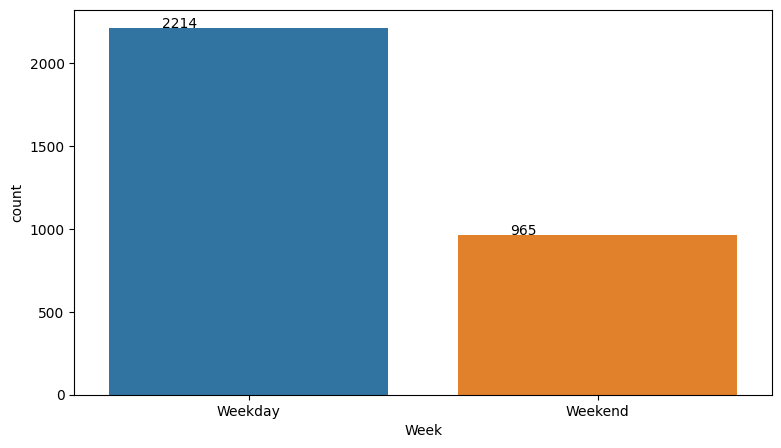

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='Week', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

In [ ]:
average_weekday = week.loc[week['Hari'] == 'Weekday', 'Jumlah pengunjung'].values[0] / 5
average_weekend = week.loc[week['Hari'] == 'Weekend', 'Jumlah pengunjung'].values[0] / 2

print("Average Visitors per Weekday per Day:", average_weekday)
print("Average Visitors per Weekend per Day:", average_weekend)


Average Visitors per Weekday per Day: 442.8
Average Visitors per Weekend per Day: 482.5


Dari data di atas dapat disimpulkan bahwa rata-rata customer lebih tinggi pada weekend (482.5) dibanding dengan weekday (442.8) karena jumlah tertinggi customer didapat pada hari Sabtu. Namun jumlah ini tidak terlalu signifikan dan penjualan relatif stabil baik pada weekday maupun weekend.

In [ ]:
df.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant,Jam,Hari,Bulan,Year,Week
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,21,Monday,April,2021,Weekday
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,22,Saturday,April,2021,Weekend
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,14,Saturday,April,2021,Weekend
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,13,Tuesday,April,2021,Weekday
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,17,Tuesday,April,2021,Weekday


10. Melihat jumlah transaksi setiap jamnya

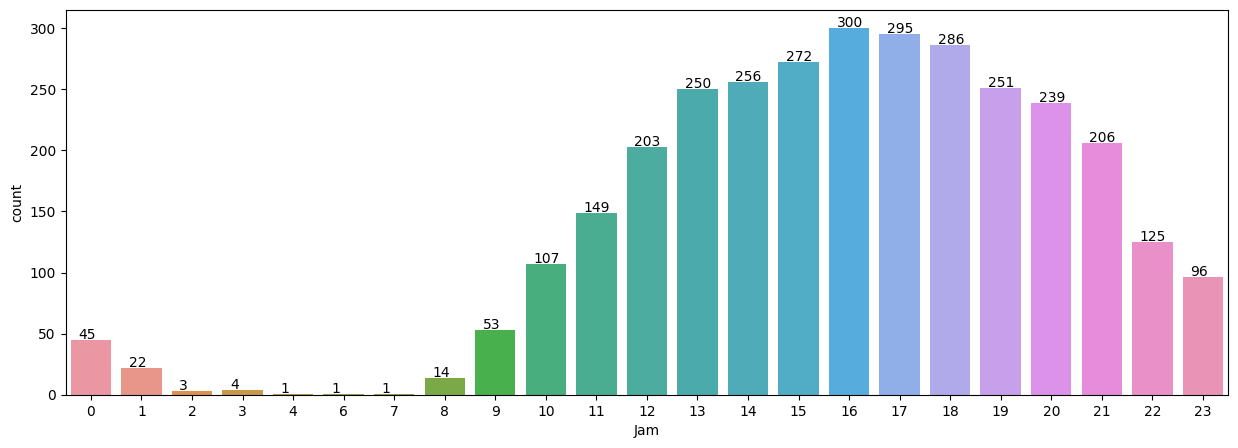

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='Jam', data=df)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

Customer lebih banyak melakukan transaksi sekitar pukul 13.00- 21.00,  karena biasanya merchant akan melakukan penjualan makanan berlebih ketika jam makan siang dan makan malam berakhir sekitar pukul jam 1 atau jam 2 siang dan jam 8 atau jam 9 malam.

#### FEATURE SELECTION

MENGECEK PLAGIAT DARI KOLOM "KABKOT" DAN "KECAMATAN"

In [ ]:
# Mengidentifikasi apakah terdapat duplicate value pada tabel dengan acuan kolom 'kabkot' DAN 'Kota/Kabupaten'
df[df[["kabkot","Kota/Kabupaten"]].duplicated(keep=False)].sort_values("kabkot")
df.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant,Jam,Hari,Bulan,Year,Week
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,21,Monday,April,2021,Weekday
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,22,Saturday,April,2021,Weekend
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,14,Saturday,April,2021,Weekend
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,13,Tuesday,April,2021,Weekday
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,17,Tuesday,April,2021,Weekday


In [ ]:
# Mengidentifikasi apakah terdapat duplicate value pada tabel dengan acuan kolom 'kecamatan' DAN 'Kecamatan'
df[df[["kecamatan","Kecamatan"]].duplicated(keep=False)].sort_values("kecamatan")
df.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Kota/Kabupaten,Kecamatan,Status_Merchant,Jam,Hari,Bulan,Year,Week
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,21,Monday,April,2021,Weekday
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,22,Saturday,April,2021,Weekend
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,14,Saturday,April,2021,Weekend
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,13,Tuesday,April,2021,Weekday
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,KOTA BANDUNG,SUKASARI,Silver,17,Tuesday,April,2021,Weekday


Setelah dilakukan cek duplikat data pada kolom 'kabkot' dengan 'Kota/Kabupaten' serta kolom 'kecamatan' dengan 'Kecamatan' didapatkan hasil bahwa :

1.   Data pada kolom 'kabkot' 100% sama dengan data pada kolom 'Kota/Kabupaten'
2.   Data pada kolom 'kecamatan' 100% sama dengan data pada kolom 'Kecamatan'

Maka dapat diputuskan bahwa kolom 'Kota/Kabupaten' dan kolom 'Kecamatan' didrop atau dihapus

In [ ]:
# Menghapus kolom 'Kota/Kabupaten' dan kolom 'Kecamatan'
df = df.drop(['Kota/Kabupaten'], axis=1)
df = df.drop(['Kecamatan'], axis=1)
df

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Status_Merchant,Jam,Hari,Bulan,Year,Week
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,21,Monday,April,2021,Weekday
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,22,Saturday,April,2021,Weekend
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,14,Saturday,April,2021,Weekend
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,13,Tuesday,April,2021,Weekday
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,17,Tuesday,April,2021,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3174,756199,2022-06-03 07:58:00,45397,5528,KOTA TANGERANG,KARANG TENGAH,SELF PICKUP,-,Points,Minimarket,2022-05-30 9:53:44,BANTEN,Platinum,7,Friday,June,2022,Weekday
3175,234424,2021-07-15 18:48:00,7966,9636,KOTA JAKARTA BARAT,KEMBANGAN,SELF PICKUP,-,GoPay,Coffe Shop,2020-10-28 5:01:04,DKI JAKARTA,Silver,18,Thursday,July,2021,Weekday
3176,947160,2021-09-01 03:06:00,10274,9636,KOTA JAKARTA BARAT,KEMBANGAN,GOSEND,Instant,Points,Coffe Shop,2020-10-28 5:01:04,DKI JAKARTA,Silver,3,Wednesday,September,2021,Weekday
3177,931621,2021-09-01 13:07:00,9873,9636,KOTA JAKARTA BARAT,KEMBANGAN,GOSEND,Instant,Dana,Coffe Shop,2020-10-28 5:01:04,DKI JAKARTA,Silver,13,Wednesday,September,2021,Weekday


In [ ]:
# Drop variabel yang tidak dibutuhkan
cluster_data = df.drop(["transaction_id",	"date",	"customer_id", 	"merchant_id","kabkot","kecamatan", "Tanggal Bergabung"], axis = 1)
cluster_data.head()

,shipment_provider,shipment_method,payment_method,Kategori,Provinsi,Status_Merchant,Jam,Hari,Bulan,Year,Week
0,GOSEND,Instant,Dana,Minimarket,JAWA BARAT,Silver,21,Monday,April,2021,Weekday
1,GOSEND,Instant,Dana,Minimarket,JAWA BARAT,Silver,22,Saturday,April,2021,Weekend
2,GOSEND,Instant,Dana,Minimarket,JAWA BARAT,Silver,14,Saturday,April,2021,Weekend
3,GOSEND,Instant,ShopeePay,Minimarket,JAWA BARAT,Silver,13,Tuesday,April,2021,Weekday
4,SELF PICKUP,-,Dana,Minimarket,JAWA BARAT,Silver,17,Tuesday,April,2021,Weekday


Diatas ada beberapa kolomnya yang tidak dibutuhkan maka melakukan drop/penghapusan kolom diantaranya kolom transaction_id,	date,	customer_id, 	merchant_id, kabkot,kecamatan, dan Tanggal Bergabung variabel/kolom. Karena tidak digunakan dalam analisi clustering selanjutnya.

ENCODING CATEGORICAL

In [ ]:
# Merubah data kategori menjadi numerik
label_encoder = LabelEncoder()
categorical = ["shipment_provider", "shipment_method","payment_method", "Kategori",	"Provinsi", "Status_Merchant", 	"Jam",	"Hari",	"Week", "Bulan", "Year"]
encoded_data = df[categorical].apply(label_encoder.fit_transform)

cluster_data = encoded_data

cluster_data.head()

,shipment_provider,shipment_method,payment_method,Kategori,Provinsi,Status_Merchant,Jam,Hari,Week,Bulan,Year
0,0,1,0,4,4,3,20,1,0,0,0
1,0,1,0,4,4,3,21,2,1,0,0
2,0,1,0,4,4,3,13,2,1,0,0
3,0,1,4,4,4,3,12,5,0,0,0
4,2,0,0,4,4,3,16,5,0,0,0


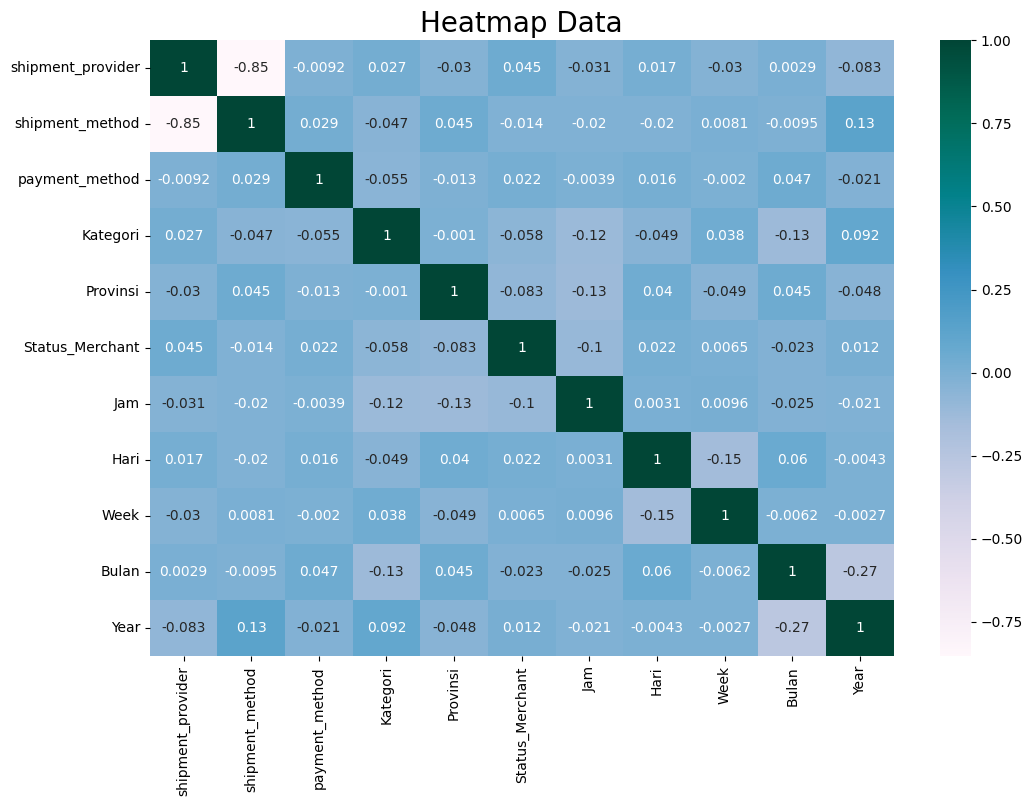

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(cluster_data.corr(), cmap = 'PuBuGn', annot = True)
plt.title('Heatmap Data', fontsize = 20)
plt.show()

In [ ]:
cluster_data.corr().sum()

shipment_provider    0.055856
shipment_method      0.250991
payment_method       1.009432
Kategori             0.701840
Provinsi             0.779058
Status_Merchant      0.826771
Jam                  0.566002
Hari                 0.935960
Week                 0.824306
Bulan                0.692292
Year                 0.785264
dtype: float64

In [ ]:
#Drop variabel yang tidak dibutuhkan
cluster_data = cluster_data.drop(["shipment_provider", "Year"], axis = 1)

drop shipment provider karena data shipment method dan provider cenderung sama, dan dika dilihat kroelasinya lebih tinggi yang provider jd ambil yg provider.

drop data year karena data disini hanya terdiri dari 2 data tahun shg tidak terlalu diperlukan dalam clustering.

SCALLING

In [ ]:
scaler = StandardScaler()
cluster_data[["shipment_method","payment_method","Kategori","Provinsi","Status_Merchant",	"Jam",	"Hari", "Bulan"]] = scaler.fit_transform(cluster_data[["shipment_method","payment_method","Kategori","Provinsi","Status_Merchant",	"Jam",	"Hari", "Bulan"]])
cluster_data.head()

,shipment_method,payment_method,Kategori,Provinsi,Status_Merchant,Jam,Hari,Week,Bulan
0,0.699648,-1.054513,-0.511637,0.895919,1.189374,1.217943,-0.952154,0,-1.349171
1,0.699648,-1.054513,-0.511637,0.895919,1.189374,1.457196,-0.450514,1,-1.349171
2,0.699648,-1.054513,-0.511637,0.895919,1.189374,-0.456832,-0.450514,1,-1.349171
3,0.699648,2.116257,-0.511637,0.895919,1.189374,-0.696085,1.054407,0,-1.349171
4,-0.811344,-1.054513,-0.511637,0.895919,1.189374,0.260929,1.054407,0,-1.349171


#### MODELING

Menentukan nilai optimal kelompok

In [ ]:
# Perulangan ini digunakan untuk mengeksekusi nilai k dengan data
# Selanjutkan akan dicari SSE
Sum_of_squared_error = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_data)
    Sum_of_squared_error.append(km.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

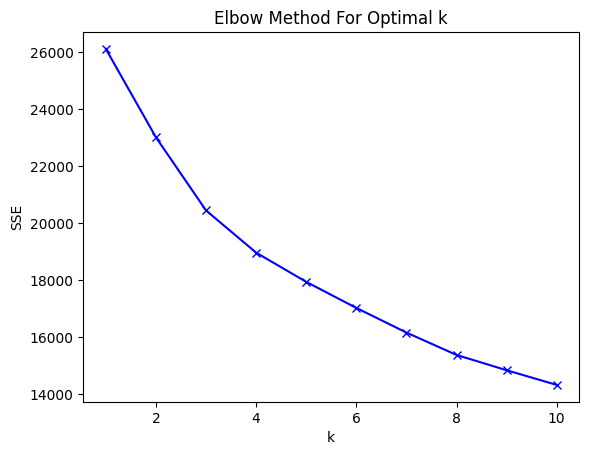

In [ ]:
plt.plot(K, Sum_of_squared_error, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

Berdasarkan metode elbow pada titik siku-siku diperoleh di k=3 atau k=4, dalam pengaplikasian metode elbow pemilihan k optimal dipilih ketika jarak antara jumlah 1 dan yang lain tidak berbeda secara signifikan. Pada kasus ini nilai k yang optimal adalah 4 dikarenakan jarak antara 2 dan 3 terlalu jauh. Namun untuk memastikan, akan dievaluasi dengan menggunakan silhouette score.

#### EVALUATION

In [ ]:
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters)
    preds = clusterer.fit_predict(cluster_data)
    centers = clusterer.cluster_centers_

    score = silhouette_score(cluster_data, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 2, silhouette score is 0.14311703713564006


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 3, silhouette score is 0.1509496770120214


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 4, silhouette score is 0.13559182174858972


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 5, silhouette score is 0.13429235972475115


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 6, silhouette score is 0.14029388034092166


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 7, silhouette score is 0.13512378884508286


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 8, silhouette score is 0.14110930821040377


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 9, silhouette score is 0.1472358420388537


Dari silhoutte score didapat bahwa score tertinggi terletak di k=3 yaitu 0.1509496770120214, dengan mempertimbangkan elbow method maka  didapat bahwa k optimum adalah 3.

Memodelkan data dengan K-means

In [ ]:
cluster = KMeans(n_clusters=3, random_state = 42)
cluster_labels = cluster.fit_predict(cluster_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



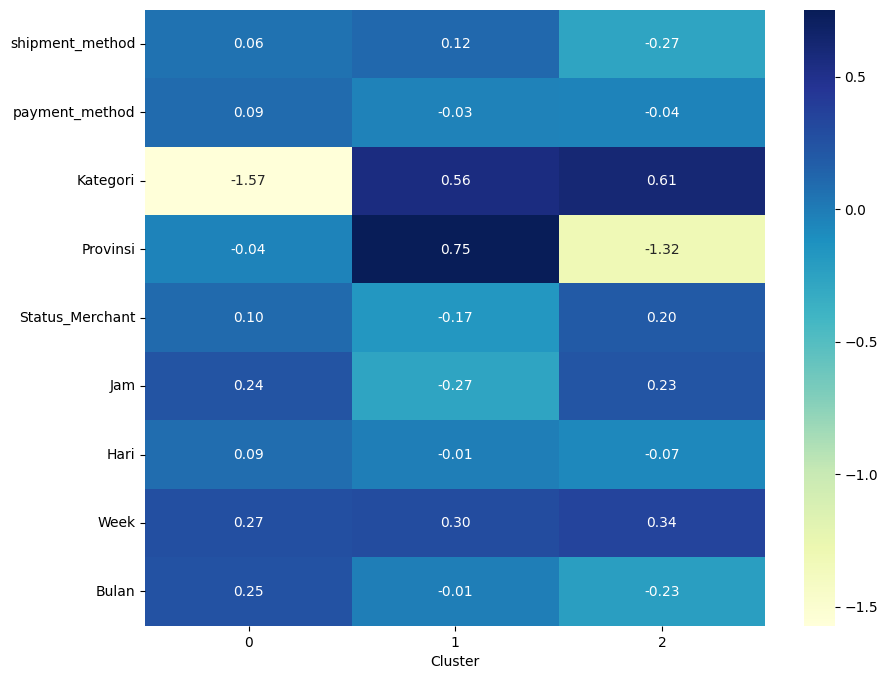

In [ ]:
cluster_data['Cluster'] = cluster_labels
clustered_data = cluster_data.groupby("Cluster").mean()
plt.figure(figsize=(10, 8))
sns.heatmap(clustered_data.T, cmap='YlGnBu', annot=True, fmt=".2f")
plt.show()

In [ ]:
# Membuat kolom baru berdasarkan hasil clustering
segment = pd.Series(cluster.labels_, name="segment")

In [ ]:
# Menggabungkan data dengan hasil cluster
results = pd.concat([df, segment], axis=1)
results.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Status_Merchant,Jam,Hari,Bulan,Year,Week,segment
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,21,Monday,April,2021,Weekday,1
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,22,Saturday,April,2021,Weekend,0
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,14,Saturday,April,2021,Weekend,1
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,13,Tuesday,April,2021,Weekday,1
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,17,Tuesday,April,2021,Weekday,1


Menampilkan data setiap cluster

In [ ]:
# Menampilkan data teratas dari cluster 1
cluster1 = results[results["segment"]==0]
cluster1.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Status_Merchant,Jam,Hari,Bulan,Year,Week,segment
1,693828,2021-04-03 22:36:00,4539,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,22,Saturday,April,2021,Weekend,0
9,143169,2021-04-08 21:07:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,21,Thursday,April,2021,Weekday,0
11,475823,2021-04-07 21:16:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,21,Wednesday,April,2021,Weekday,0
13,864395,2021-05-02 15:14:00,5205,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Points,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,15,Sunday,May,2021,Weekend,0
18,471234,2021-06-29 17:13:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,17,Tuesday,June,2021,Weekday,0


In [ ]:
# Menampilkan data teratas dari cluster 2
cluster2 = results[results["segment"]==1]
cluster2.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Status_Merchant,Jam,Hari,Bulan,Year,Week,segment
0,329996,2021-04-05 21:28:00,4290,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,21,Monday,April,2021,Weekday,1
2,126888,2021-04-03 14:14:00,4550,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,14,Saturday,April,2021,Weekend,1
3,234871,2021-04-06 13:02:00,4542,8153,KOTA BANDUNG,SUKASARI,GOSEND,Instant,ShopeePay,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,13,Tuesday,April,2021,Weekday,1
4,945801,2021-04-06 17:37:00,4554,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,17,Tuesday,April,2021,Weekday,1
5,360529,2021-04-06 14:34:00,4553,8153,KOTA BANDUNG,SUKASARI,SELF PICKUP,-,Dana,Minimarket,2021-03-30 17:28:50,JAWA BARAT,Silver,14,Tuesday,April,2021,Weekday,1


In [ ]:
# Menampilkan data teratas dari cluster 2
cluster3 = results[results["segment"]==2]
cluster3.head()

,transaction_id,date,customer_id,merchant_id,kabkot,kecamatan,shipment_provider,shipment_method,payment_method,Kategori,Tanggal Bergabung,Provinsi,Status_Merchant,Jam,Hari,Bulan,Year,Week,segment
125,161121,2021-04-17 21:59:00,4014,8527,KOTA JAKARTA PUSAT,MENTENG,GOSEND,Instant,Dana,Supermarket,2021-03-23 19:02:24,DKI JAKARTA,Gold,21,Saturday,April,2021,Weekend,2
128,930719,2021-04-17 19:47:00,4824,5969,KOTA JAKARTA BARAT,PALMERAH,SELF PICKUP,-,Dana,Supermarket,2020-06-19 7:17:39,DKI JAKARTA,Gold,19,Saturday,April,2021,Weekend,2
452,660381,2021-09-15 19:32:00,13083,4051,KOTA JAKARTA PUSAT,MENTENG,SELF PICKUP,-,Dana,Toko Kelontong,2021-03-23 11:30:46,DKI JAKARTA,Silver,19,Wednesday,September,2021,Weekday,2
454,166382,2022-05-02 16:33:00,17887,4051,KOTA JAKARTA PUSAT,MENTENG,SELF PICKUP,-,OvO,Toko Kelontong,2021-03-23 11:30:46,DKI JAKARTA,Silver,16,Monday,May,2022,Weekday,2
466,563106,2021-12-01 19:33:00,743,9204,KOTA JAKARTA PUSAT,MENTENG,SELF PICKUP,-,GoPay,Supermarket,2021-03-23 13:37:00,DKI JAKARTA,Platinum,19,Wednesday,December,2021,Weekday,2


#### EXPLORATORY DATA ANALYSIS CLUSTER

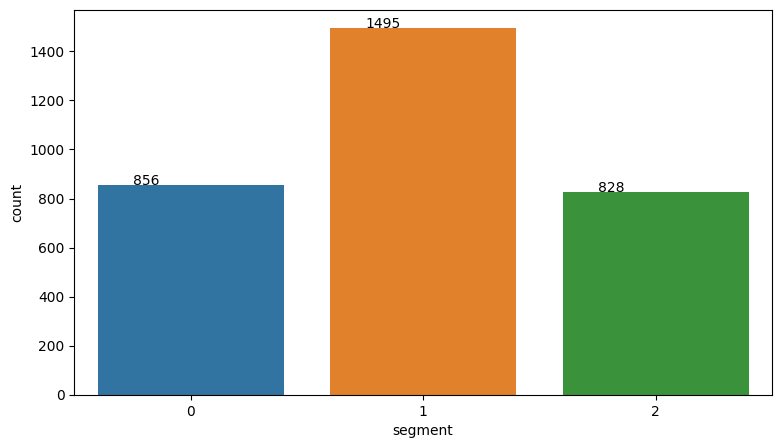

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
s = sns.countplot(x='segment', data=results)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))

In [ ]:
segment.value_counts()

1    1495
0     856
2     828
Name: segment, dtype: int64

Cluster terbagi menjadi 3, yaitu cluster 0, cluster 1 dan cluster 2. Cluster 0 memiliki jumlah sebanyak 856 dan cluster 1 memiliki jumlah sebanyak 1495 dan cluster 2 memiliki jumlah sebanyak 828.

1. Analisis Pengiriman dalam setiap cluster

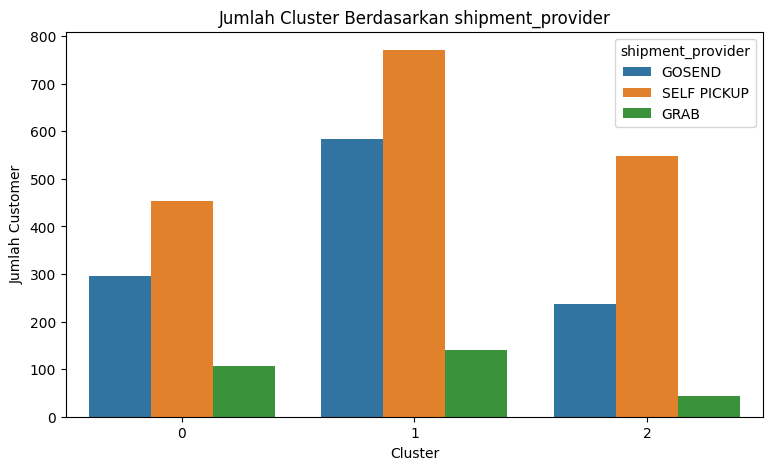

In [ ]:
# Melihat grafik data shipment provider pada setiap cluster
plt.figure(figsize=(9,5))
sns.countplot(x="segment", data=results, hue="shipment_provider")
plt.title("Jumlah Cluster Berdasarkan shipment_provider")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["shipment_provider"].value_counts()

segment  shipment_provider
0        SELF PICKUP          453
         GOSEND               296
         GRAB                 107
1        SELF PICKUP          771
         GOSEND               583
         GRAB                 141
2        SELF PICKUP          549
         GOSEND               236
         GRAB                  43
Name: shipment_provider, dtype: int64

- Cluster 0 merupakan kelompok yang banyak melakukan transaksi dengan pengambilan makanan Self Picup dan GOSEND, tetapi Self Picup yang paling mendominasi.
- Cluster 1 merupakan kelompok yang banyak melakukan transaksi dengan pengambilan makanan melalui Self Picup paling besar dari cluster lainnya.
- Cluster 2 merupakan kelompok yang banyak melakukan transaksi dengan pengambilan makanan melalui Self Picup dan GOSEND tapi Self Picup yang mendominasi.






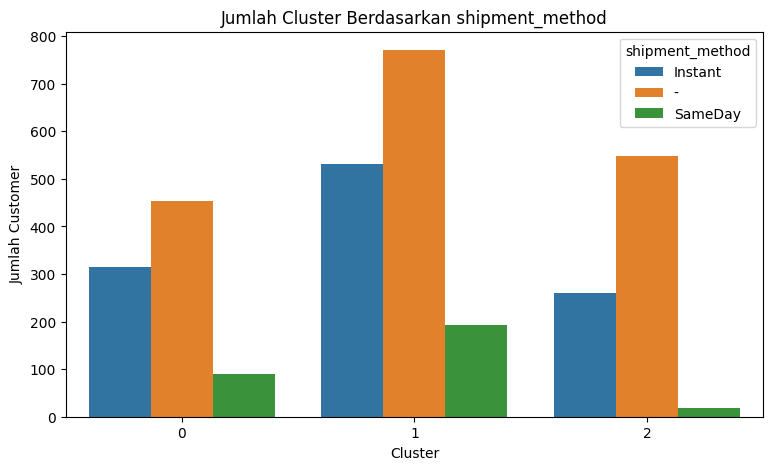

In [ ]:
# Melihat grafik data shipment method pada setiap cluster
plt.figure(figsize=(9,5))
sns.countplot(x="segment", data=results, hue="shipment_method")
plt.title("Jumlah Cluster Berdasarkan shipment_method")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["shipment_method"].value_counts()

segment  shipment_method
0        -                  453
         Instant            314
         SameDay             89
1        -                  771
         Instant            531
         SameDay            193
2        -                  549
         Instant            260
         SameDay             19
Name: shipment_method, dtype: int64

- Cluster 0 merupakan kelompok yang banyak melakukan transaksi dengan metode pengiriman (-) yang disediakan karena customer melakukan transaksi secara langsung ke lokasi merchant. <br>
- Cluster 1 merupakan kelompok yang banyak melakukan transaksi dengan metode pengiriman (-) yang disediakan karena customer melakukan transaksi secara langsung ke lokasi merchant.
- Cluster 2 merupakan kelompok yang banyak melakukan transaksi dengan metode pengiriman (-) yang disediakan karena customer melakukan transaksi secara langsung ke lokasi merchant.


2. Melihat Item yang dijual oleh setiap merchant dalam setiap cluster

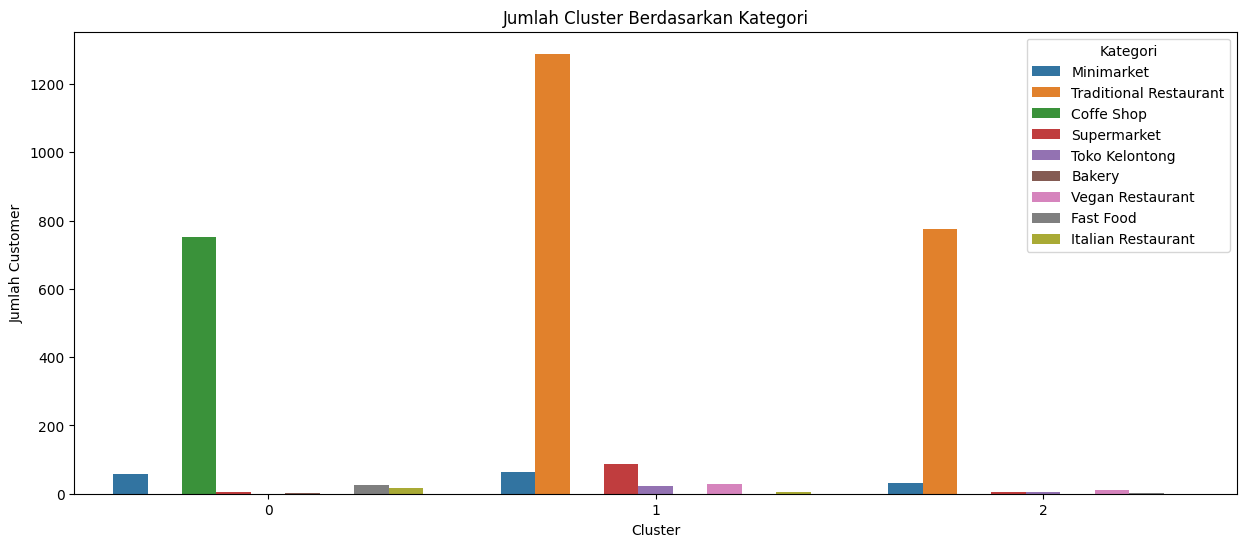

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(x="segment", data=results, hue="Kategori")
plt.title("Jumlah Cluster Berdasarkan Kategori")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["Kategori"].value_counts()

segment  Kategori              
0        Coffe Shop                 752
         Minimarket                  57
         Fast Food                   25
         Italian Restaurant          16
         Supermarket                  4
         Bakery                       2
1        Traditional Restaurant    1289
         Supermarket                 86
         Minimarket                  64
         Vegan Restaurant            29
         Toko Kelontong              23
         Italian Restaurant           4
2        Traditional Restaurant     776
         Minimarket                  30
         Vegan Restaurant            11
         Supermarket                  6
         Toko Kelontong               4
         Fast Food                    1
Name: Kategori, dtype: int64

Ketiga cluster menunjukan perbedaan kategori/item pembelian yang cukup signifikan.
- Cluster 0 lebih dominan melakukan transaksi pada merchant  Coffe Shop 752, namun masih banya juga melakukan transaksi pada merchant lainnya seperti minimarket 57, Fast Food 25, Italian Restaurant 16, Supermarket 4, dan Bakery 2.
- Cluster 1 lebih dominan melakukan transaksi pada merchant Traditional Restaurant 1289, namun masih banya juga melakukan transaksi pada merchant lainnya seperti  Supermarket 86, Minimarket 64, Vegan Restaurant 29, Toko Kelontong 23, dan Italian Restaurant 4.
- Cluster 2 lebih dominan melakukan transaksi pada merchant Traditional Restaurant 776, namun masih banya juga melakukan transaksi pada merchant lainnya seperti Minimarket 30, Vegan Restaurant 11, Supermarket 6 dan Toko Kelo 1.



3. Analisis Lokasi Merchant dalam setiap cluster

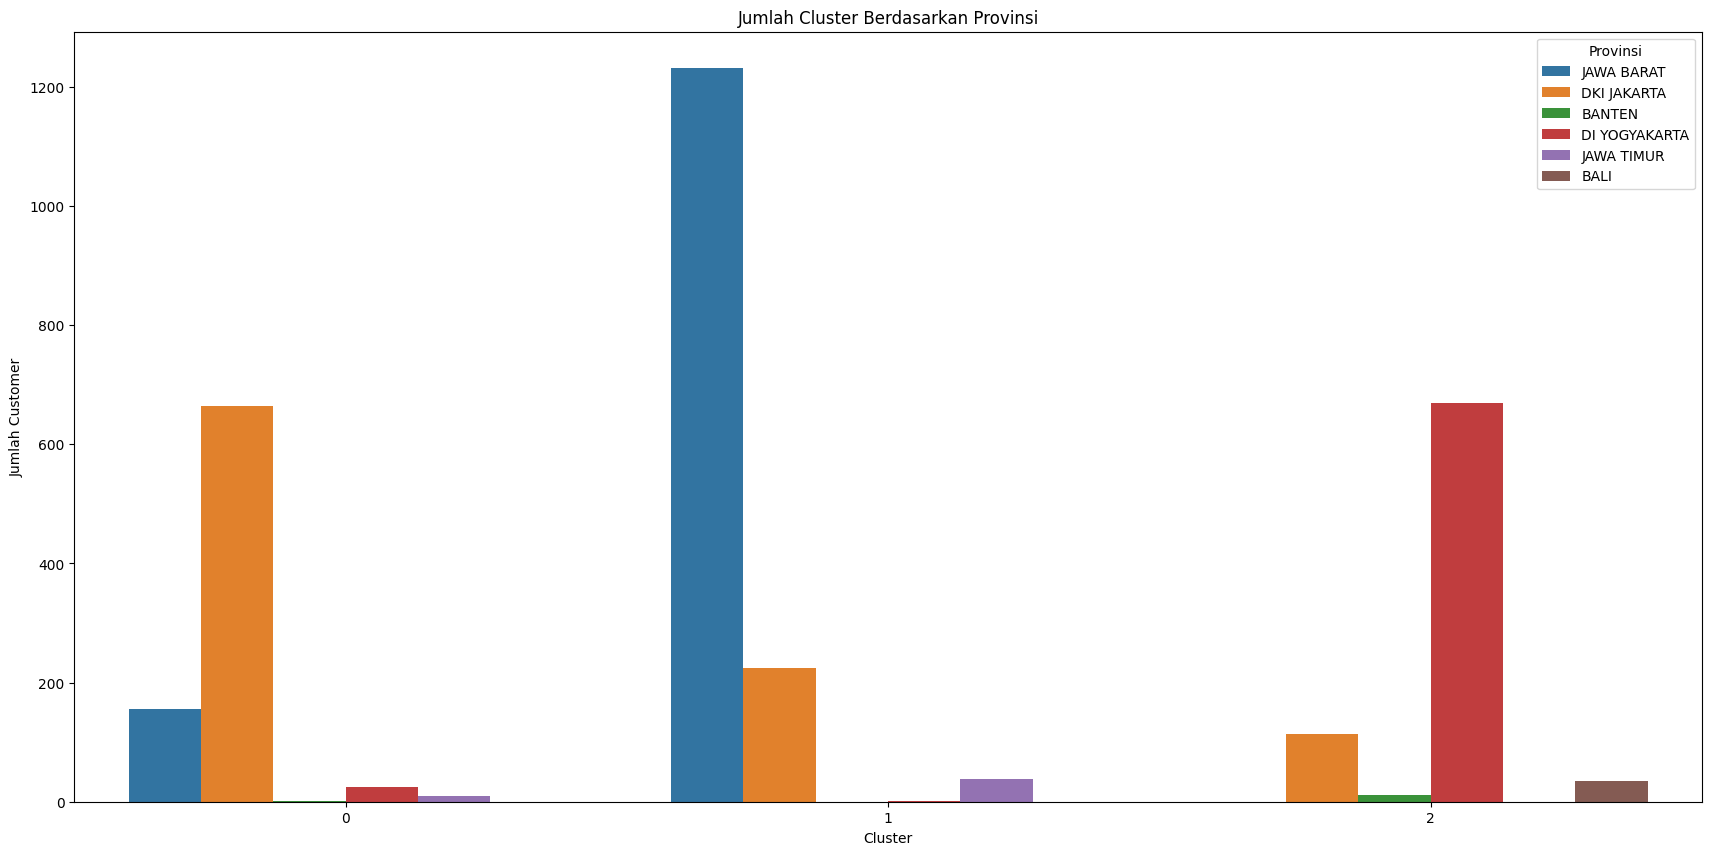

In [ ]:
plt.figure(figsize=(21,10))
sns.countplot(x="segment", data=results, hue="Provinsi")
plt.title("Jumlah Cluster Berdasarkan Provinsi")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["Provinsi"].value_counts()

segment  Provinsi     
0        DKI JAKARTA       664
         JAWA BARAT        156
         DI YOGYAKARTA      25
         JAWA TIMUR          9
         BANTEN              2
1        JAWA BARAT       1231
         DKI JAKARTA       224
         JAWA TIMUR         38
         DI YOGYAKARTA       2
2        DI YOGYAKARTA     670
         DKI JAKARTA       113
         BALI               34
         BANTEN             11
Name: Provinsi, dtype: int64

- Cluster 0 merupakan kelompok yang banyak melakukan transaksi di wilayah provinsi DKI Jakarta.
- Cluster 1 merupakan kelompok yang banyak melakukan transaksi di wilayah provinsi Jawa Barat.
- Cluster 2 merupakan kelompok yang banyak melakukan transaksi di wilayah provinsi DI Yogyakarta.

4. Analisis Status Merchant dalam setiap cluster

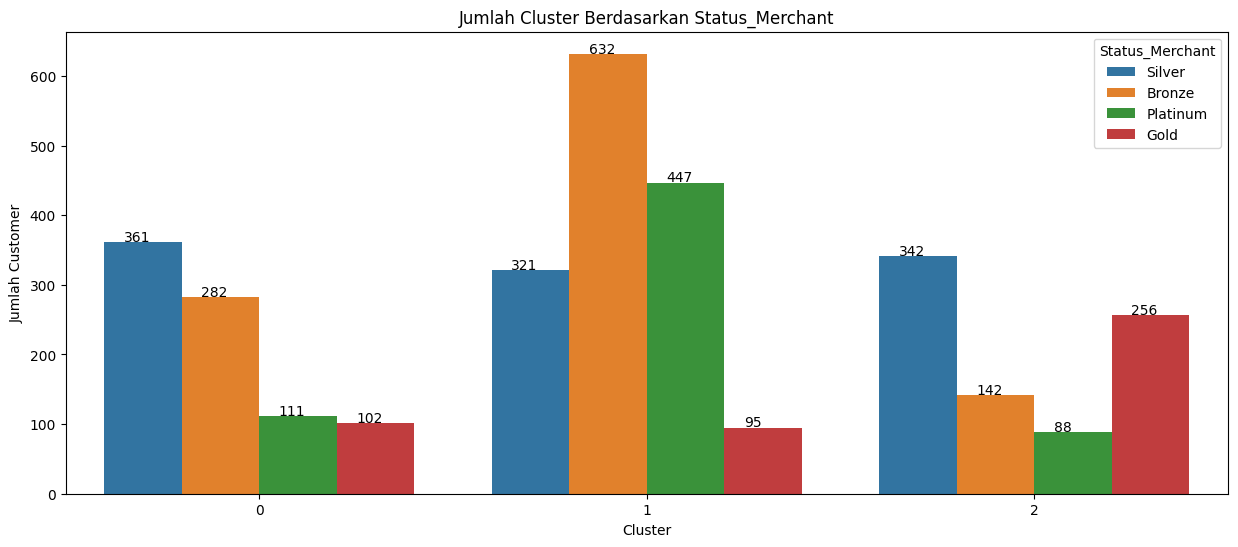

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
s = sns.countplot(x="segment", data=results, hue="Status_Merchant")
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.05, s.get_height()+1))
plt.title("Jumlah Cluster Berdasarkan Status_Merchant")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["Status_Merchant"].value_counts()

segment  Status_Merchant
0        Silver             361
         Bronze             282
         Platinum           111
         Gold               102
1        Bronze             632
         Platinum           447
         Silver             321
         Gold                95
2        Silver             342
         Gold               256
         Bronze             142
         Platinum            88
Name: Status_Merchant, dtype: int64

- Cluster 0 merupakan kelompok yang banyak melakukan transaksi pada merchant yang memiliki status Silver (361) Bronze (282), Platinum (111), dan Gold (102), . <br>
- Cluster 1 merupakan kelompok yang banyak melakukan transaksi pada merchant yang memiliki status Silver (632),  Platinum (612), Gold (102).
* Cluster 2 merupakan kelompok yang banyak melakukan transaksi pada merchant yang memiliki status Silver (342),  Gold (256), Brize(142), dan Platinum (88).



5. Analisis Metode Pembayaran dalam setiap cluster

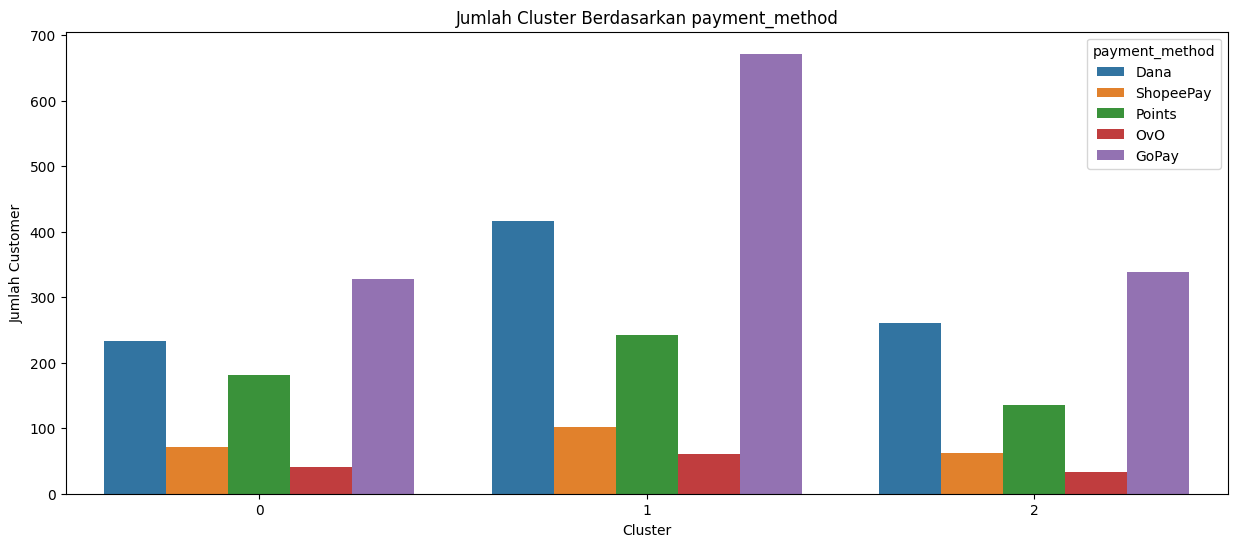

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(x="segment", data=results, hue="payment_method")
plt.title("Jumlah Cluster Berdasarkan payment_method")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["payment_method"].value_counts()

segment  payment_method
0        GoPay             328
         Dana              234
         Points            181
         ShopeePay          72
         OvO                41
1        GoPay             672
         Dana              417
         Points            243
         ShopeePay         102
         OvO                61
2        GoPay             338
         Dana              260
         Points            135
         ShopeePay          62
         OvO                33
Name: payment_method, dtype: int64

- Cluster 0 merupakan kelompok yang banyak melakukan transaksi pembayaran menggunakan Gopay (324) Dana (234), Points (181), ShopeePay (72), dan OvO (41).
- Cluster 1 merupakan kelompok yang banyak melakukan transaksi pembayaran menggunakan Gopay (672), Dana (417), Points (243), ShopeePay (102), dan OvO (61).
- Cluster 2 merupakan kelompok yang banyak melakukan transaksi pembayaran menggunakan Gopay (338), Dana (260), Points (135), ShopeePay (62), dan OvO (33).



6. Melihat transaksi bulanan dalam setiap cluster

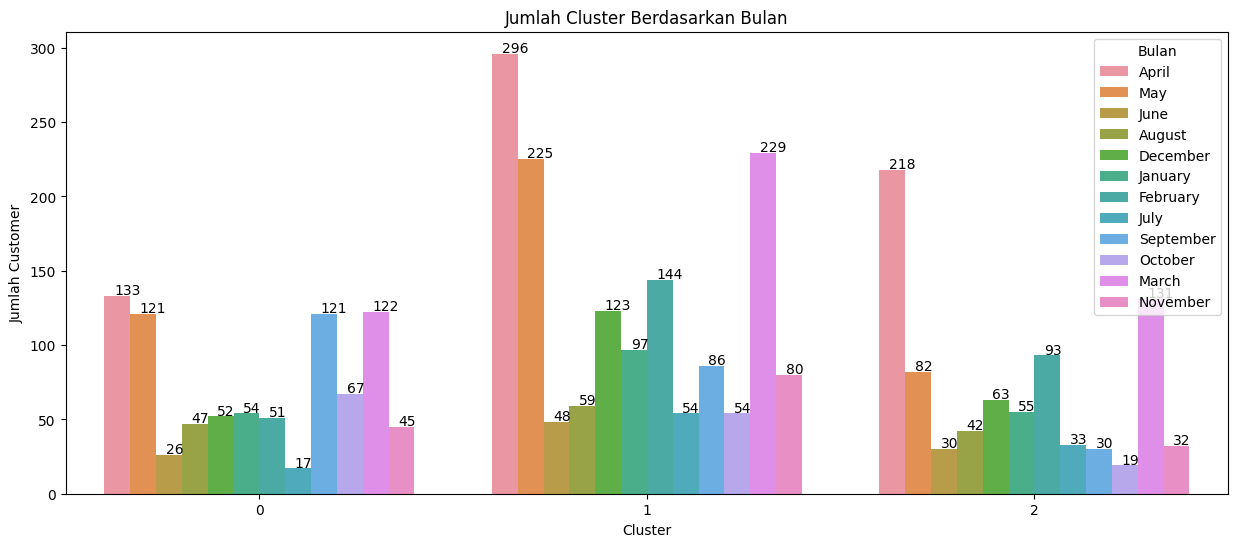

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
s = sns.countplot(x="segment", data=results, hue="Bulan")
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.025, s.get_height()+1))
plt.title("Jumlah Cluster Berdasarkan Bulan")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["Bulan"].value_counts()

segment  Bulan    
0        April        133
         March        122
         May          121
         September    121
         October       67
         January       54
         December      52
         February      51
         August        47
         November      45
         June          26
         July          17
1        April        296
         March        229
         May          225
         February     144
         December     123
         January       97
         September     86
         November      80
         August        59
         July          54
         October       54
         June          48
2        April        218
         March        131
         February      93
         May           82
         December      63
         January       55
         August        42
         July          33
         November      32
         June          30
         September     30
         October       19
Name: Bulan, dtype: int64

- Cluster 0 jumlah transaksi banyak dilakukan pada bulan April 133, March 122, May 121 dan September 121. Namun yang mendominasi banyak terjadinya pada periode 1 tahun ini pada bulan April dengan 133 transaksi.
- Cluster 1 jumlah transaksi banyak dilakukan pada bulan April 296, March 229, dan May 225. Namun yang mendominasi banyak terjadinya pada periode 1 tahun ini pada bulan April dengan 296 transaksi.
- Cluster 2 jumlah transaksi banyak dilakukan pada bulan April 218, March 131. Namun yang mendominasi banyak terjadinya pada periode 1 tahun ini pada bulan April dengan 218 transaksi.



5. Melihat transaksi Mingguan dalam setiap cluster

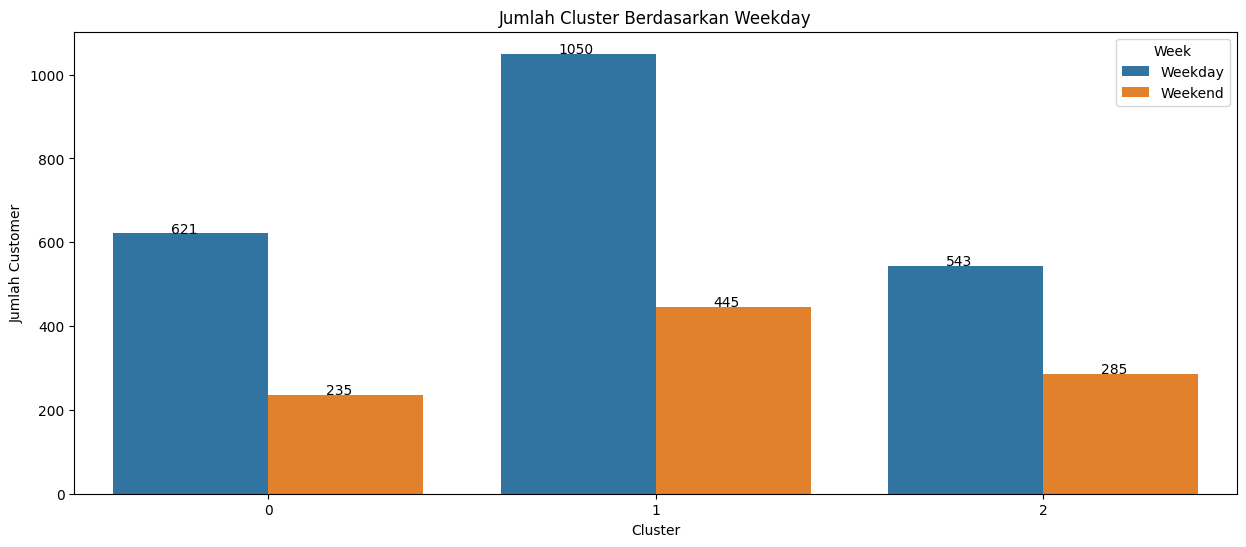

In [ ]:
# Melihat grafik data Kategori pada setiap cluster
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
s = sns.countplot(x="segment", data=results, hue="Week")
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))
plt.title("Jumlah Cluster Berdasarkan Weekday")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["Week"].value_counts()

segment  Week   
0        Weekday     621
         Weekend     235
1        Weekday    1050
         Weekend     445
2        Weekday     543
         Weekend     285
Name: Week, dtype: int64

- Cluster 0 jumlah transaksi yang banyak dilakukan pada hari-hari Weekday 621 sedangkan pada hari-hari weekend lebih sedikit dibandingkan dengan pada hari weekday yaitu 235 jumlah transaksi pada hari-hari weekend.
- Cluster 1 jumlah transaksi yang banyak dilakukan pada hari-hari Weekday 1050 sedangkan pada hari-hari weekend lebih sedikit dibandingkan dengan pada hari weekday yaitu 445 jumlah transaksi pada hari-hari weekend.
- Cluster 2 jumlah transaksi yang banyak dilakukan pada hari-hari Weekday 543 sedangkan pada hari-hari weekend lebih sedikit dibandingkan dengan pada hari weekday yaitu 285 jumlah transaksi pada hari-hari weekend.


Maka dapat disimpulkan dari 3 cluster diatas rata-rata banyak jumlah transaksi yang dilakukan oleh customer pada hari-hari weekenday.

In [ ]:
# Menghitung rata-rata data weekday
weekday_mean = results.groupby("segment")["Week"].value_counts().loc[:, "Weekday"] / 5

# Menghitung rata-rata data weekend
weekend_mean = results.groupby("segment")["Week"].value_counts().loc[:, "Weekend"] / 2

# Menampilkan rata-rata data weekday
print("Rata-rata data weekday:")
print(weekday_mean)

# Menampilkan rata-rata data weekend
print("\nRata-rata data weekend:")
print(weekend_mean)

Rata-rata data weekday:
segment
0    124.2
1    210.0
2    108.6
Name: Week, dtype: float64

Rata-rata data weekend:
segment
0    117.5
1    222.5
2    142.5
Name: Week, dtype: float64


6. Melihat transaksi Harian dalam setiap cluster

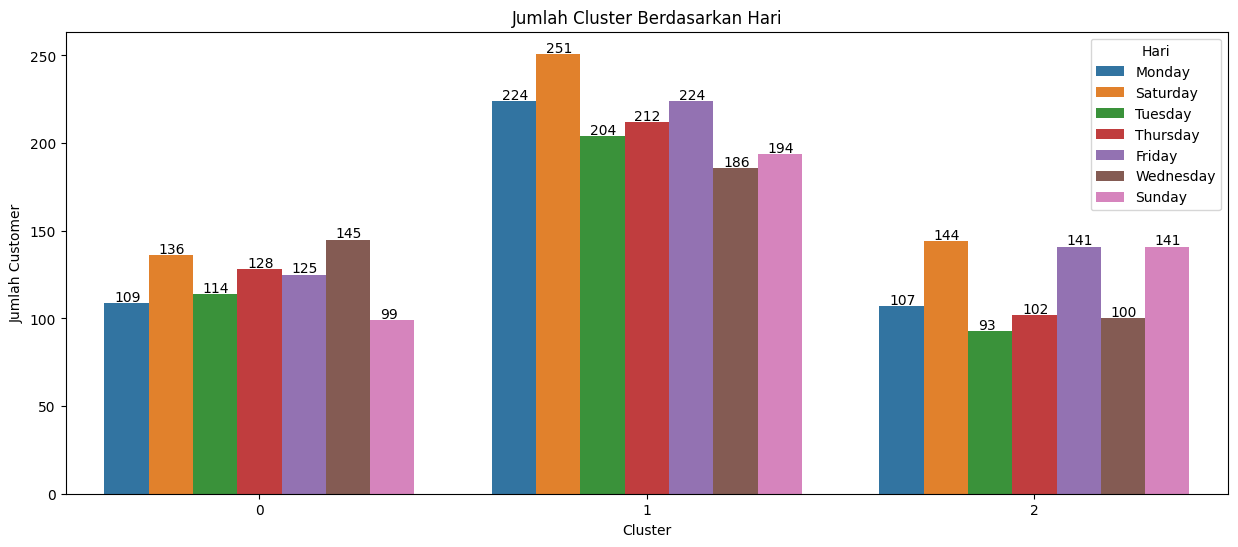

In [ ]:
# Melihat grafik data Kategori pada setiap cluster
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
s = sns.countplot(x="segment", data=results, hue="Hari")
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.025, s.get_height()+1))
plt.title("Jumlah Cluster Berdasarkan Hari")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Customer")
plt.show()

In [ ]:
results.groupby("segment")["Hari"].value_counts()

segment  Hari     
0        Wednesday    145
         Saturday     136
         Thursday     128
         Friday       125
         Tuesday      114
         Monday       109
         Sunday        99
1        Saturday     251
         Friday       224
         Monday       224
         Thursday     212
         Tuesday      204
         Sunday       194
         Wednesday    186
2        Saturday     144
         Friday       141
         Sunday       141
         Monday       107
         Thursday     102
         Wednesday    100
         Tuesday       93
Name: Hari, dtype: int64

- Cluster 0 transaksi lebih banyak pada hari Wednesday 145, yang dimana wednesday adalah hari weekday.
- Cluster 1 transaksi lebih banyak pada hari Saturday 251, yang dimana Saturday adalah hari weekend dibandingkan hari lainnya, tetapi hari-hari di weekday jumlah transaksi customer lebih stabil dibandingkan hari-hari weekend.
- Cluster 2 transaksi lebih banyak pada hari Saturday 144, yang dimana Saturday adalah hari weekend dibandingkan hari lainnya, tetapi hari-hari di weekday jumlah transaksi customer lebih stabil dibandingkan hari-hari weekend.


7. Melihat transaksi Tiap Jam dalam setiap cluster

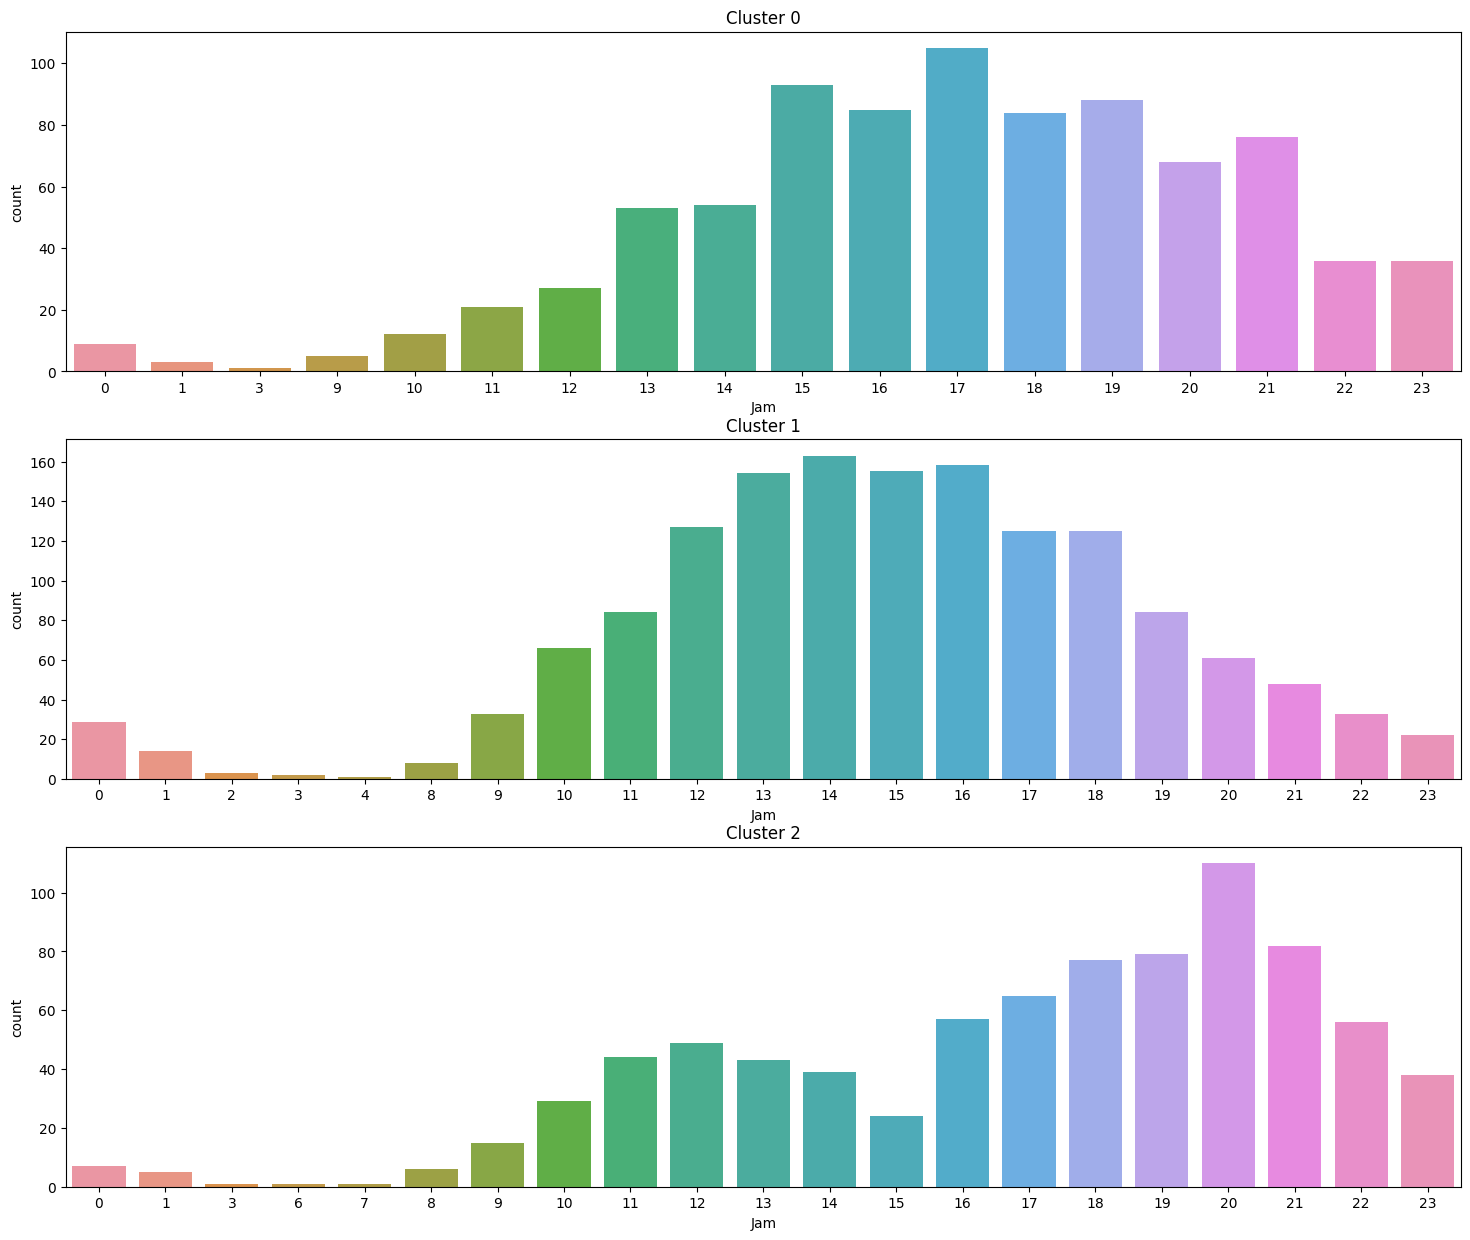

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(18,15))
sns.countplot(x='Jam', data=cluster1, ax=ax[0])
ax[0].title.set_text('Cluster 0')
sns.countplot(x='Jam', data=cluster2, ax=ax[1])
ax[1].title.set_text('Cluster 1')
sns.countplot(x='Jam', data=cluster3, ax=ax[2])
ax[2].title.set_text('Cluster 2')

- Cluster 0 merupakan kelompok yang banyak melakukan transaksi mulai pukul 09.00 hingga pukul 23.00, dimana pukul 16.00 merupakan puncak tertinggi dilakukannya transaksi. <br>
- Cluster 1 merupakan kelompok yang banyak melakukan transaksi mulai pukul 08.00 hingga pukul 23.00, dimana pukul 17.00 merupakan puncak tertinggi dilakukannya transaksi.
- Cluster 2 merupakan kelompok yang banyak melakukan transaksi mulai pukul 16.00 hingga pukul 23.00, dimana pukul 20.00 merupakan puncak tertinggi dilakukannya transaksi.

#### KESIMPULAN

Dilihat dari metode pembayaran dan pengiriman, 3 Cluster tersebut relatif melakukan pembayaran menggunakan Gopay dan Self Pickup.
*   Cluster 0 merupakan kelompok yang banyak melakukan transaksi pada merchant Coffe Shop dan pada merchant yang memiliki status Silver dan Bronze di Provinsi DKI Jakarta. Cluster ini juga memiliki jumlah transaksi harian yang relatif stabil namun rendah. Nama Cluster ini adalah "Coffee Delights".
*   Cluster 1 merupakan kelompok yang banyak melakukan transaksi pada merchant Traditional Restaurant dan pada merchant yang memiliki status Bronze dan Platinum di Provinsi Jawa Barat. Cluster ini juga memiliki jumlah transaksi harian yang stabil dan relatif tinggi. Cluster ini adalah "Gastronomic Explorers".
* Cluster 2 merupakan kelompok yang banyak melakukan transaksi pada merchant Traditional Restaurant dan pada merchant yang memiliki status Silver dan Gold di Provinsi DI Yogyakarta.Cluster ini juga memiliki jumlah transaksi harian yang relatif stabil namun sedang. Cluster ini adalah "Culinary Enthusiasts".



#### REKOMENDASI

Cluster 0: Perusahaan sebaiknya fokus untuk meningkatkan jumlah transaksi harian pada cluster ini. Meskipun jumlah transaksi rendah, stabilitas transaksi harian bisa menjadi keuntungan.
Perusahaan dapat mempertimbangkan strategi pemasaran, seperti program loyalitas atau promosi khusus untuk meningkatkan minat pelanggan pada merchant Coffee Shop
Perusahaan dapat menjalin kemitraan dengan merchant-merchant ini untuk menciptakan sinergi yang saling menguntungkan.

Cluster 1: Cluster ini memiliki jumlah transaksi harian yang stabil dan relatif tinggi. Hal ini menunjukkan bahwa pelanggan dalam cluster ini aktif dan loyal terhadap perusahaan. Rekomendasi untuk cluster ini adalah perusahaan perlu menjaga kualitas layanan dan menjaga hubungan yang baik dengan merchant Traditional Restaurant dan merchant dengan status Bronze dan Platinum di Provinsi Jawa Barat. Peningkatan kerjasama dengan merchant-merchant ini, seperti penawaran khusus atau diskon eksklusif, dapat meningkatkan loyalitas pelanggan dan mendorong pertumbuhan lebih lanjut.

Cluster 2: Perusahaan dapat mempertimbangkan strategi untuk meningkatkan minat pelanggan dalam cluster ini. Mengingat cluster ini banyak melakukan transaksi pada merchant Traditional Restaurant dan merchant dengan status Silver dan Gold di Provinsi DI Yogyakarta, perusahaan dapat melakukan kampanye pemasaran yang lebih spesifik untuk menarik perhatian pelanggan dalam cluster ini. Perusahaan juga dapat menjalin kemitraan dengan merchant-merchant ini untuk saling menguntungkan dan meningkatkan eksposur merek.

1. Jika dilihat dari persebaran wilayah pada setiap cluster yang terbentuk, perusahaan dapat melakukan perluasan jangkauan aplikasi ke area geografis yang lebih luas terutama provinsi Banten, Jawa Timur dan Bali. Dengan mencakup lebih banyak restoran dan pengguna dalam wilayah yang lebih luas, sehingga aplikasi memiliki potensi untuk mengurangi pemborosan makanan dalam skala yang lebih besar. <br>
2. Program Loyalty, dengan menawarkan program loyalitas kepada pengguna dan restoran yang berpartisipasi dalam aplikasi. Dengan memberikan insentif seperti diskon khusus, poin reward, atau keanggotaan eksklusif, aplikasi dapat mendorong pengguna untuk terus menggunakan layanan dan restoran untuk tetap berkontribusi dengan menawarkan makanan berlebih mereka.